In [1]:
### !python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Cloning into 'detectron2'...
remote: Enumerating objects: 15782, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15782 (delta 9), reused 24 (delta 6), pack-reused 15743 (from 1)
Receiving objects: 100% (15782/15782), 6.37 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (11501/11501), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.5 MB/s eta 0:00

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
torch:  2.4 ; cuda:  2.4.0
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YohwIPr0iQFNeATEe9Hc")
project = rf.workspace("telkom-university-mfinb").project("neudet-steel-surface-defects")
version = project.version(4)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 2.0 MB/s eta 0:00:00a 0:00:01
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to NEUDET-Steel-Surface-Defects-4 in coco:: 100%|██████████| 1807/1807 [00:00<00:00, 6211.66it/s]


In [ ]:
/kaggle/working/NEUDET-Steel-Surface-Defects-4/train

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/kaggle/working/NEUDET-Steel-Surface-Defects-4/train/_annotations.coco.json", "/kaggle/working/NEUDET-Steel-Surface-Defects-4/train/")
register_coco_instances("my_dataset_test", {}, "/kaggle/working/NEUDET-Steel-Surface-Defects-4/valid/_annotations.coco.json", "/kaggle/working/NEUDET-Steel-Surface-Defects-4/valid")

WARNING [10/10 12:16:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/10 12:16:40 d2.data.datasets.coco]: Loaded 1259 images in COCO format from /kaggle/working/NEUDET-Steel-Surface-Defects-4/train/_annotations.coco.json


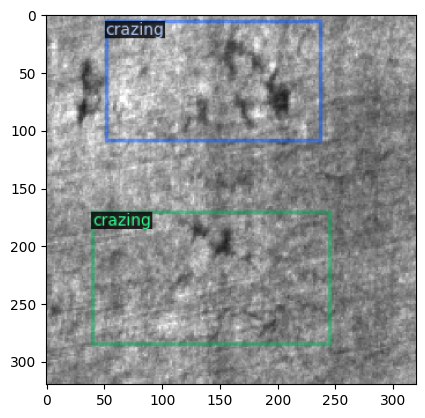

In [6]:
import matplotlib.pyplot as plt
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [7]:
num_classes = len(MetadataCatalog.get("my_dataset_train").get("thing_classes"))
num_classes

7

In [8]:
print(MetadataCatalog.get("my_dataset_train").get("thing_classes"))

['steel-surface-defects', 'crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = ""
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
# cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.RETINANET.NUM_CLASSES = 7  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/10 12:19:06 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_bfca0b.pkl: 152MB [00:00, 192MB/s]                             


[10/10 12:19:07 d2.engine.train_loop]: Starting training from iteration 0


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)


[10/10 12:19:36 d2.utils.events]:  eta: 0:09:56  iter: 19  total_loss: 2.155  loss_cls: 1.483  loss_box_reg: 0.6648    time: 1.2546  last_time: 1.2593  data_time: 0.0785  last_data_time: 0.0722   lr: 9.7405e-05  max_mem: 4179M
[10/10 12:20:20 d2.utils.events]:  eta: 0:09:33  iter: 39  total_loss: 1.688  loss_cls: 1.185  loss_box_reg: 0.5195    time: 1.2338  last_time: 1.2846  data_time: 0.0722  last_data_time: 0.0725   lr: 0.00019731  max_mem: 4181M
[10/10 12:20:44 d2.utils.events]:  eta: 0:09:09  iter: 59  total_loss: 1.365  loss_cls: 0.9683  loss_box_reg: 0.3948    time: 1.2333  last_time: 1.1695  data_time: 0.0706  last_data_time: 0.0845   lr: 0.0002972  max_mem: 4181M
[10/10 12:21:10 d2.utils.events]:  eta: 0:08:49  iter: 79  total_loss: 1.227  loss_cls: 0.8237  loss_box_reg: 0.4506    time: 1.2434  last_time: 1.1366  data_time: 0.0735  last_data_time: 0.0650   lr: 0.00039711  max_mem: 4181M
[10/10 12:21:36 d2.utils.events]:  eta: 0:08:27  iter: 99  total_loss: 1.029  loss_cls: 0.6

In [11]:
# Look at training curves in tensorboard:kkgvhjjgesfsjkssssssmghk2157asannmmkvmbbckhjqmsnngngfxfbvvcvjghhfvbnvbgngfbnbngj
%load_ext tensorboard
# %tensorboard --logdir output
%tensorboard --logdir=/kaggle/working/output/ --bind_all

[10/10 12:37:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[  9.7637,   7.6766, 628.3206, 627.4599]], device='cuda:0')), scores: tensor([0.9452], device='cuda:0'), pred_classes: tensor([4], device='cuda:0')])}


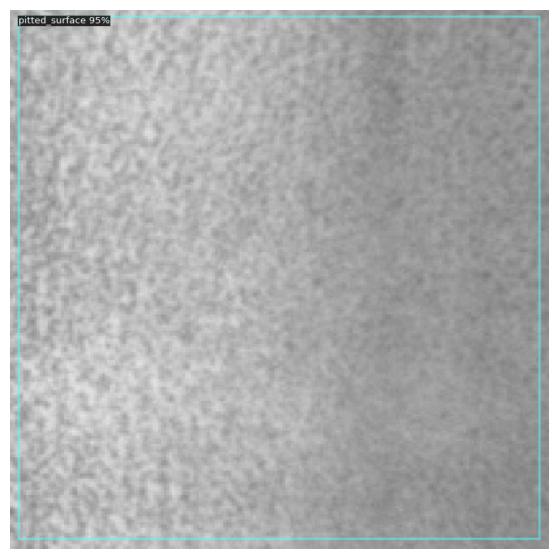

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[136.7756, 172.7132, 452.7151, 605.0856]], device='cuda:0')), scores: tensor([0.7319], device='cuda:0'), pred_classes: tensor([3], device='cuda:0')])}


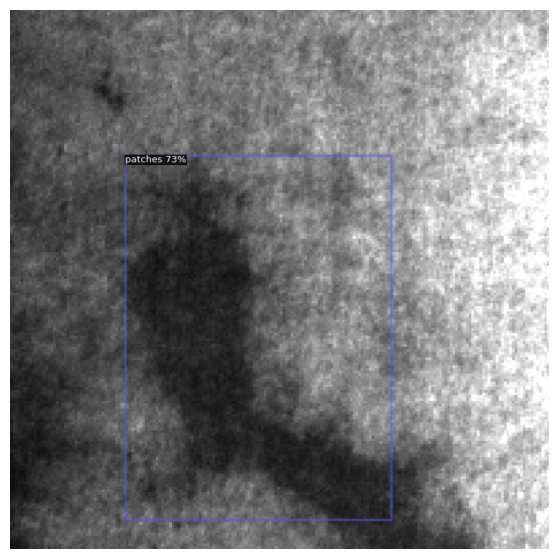

{'instances': Instances(num_instances=0, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


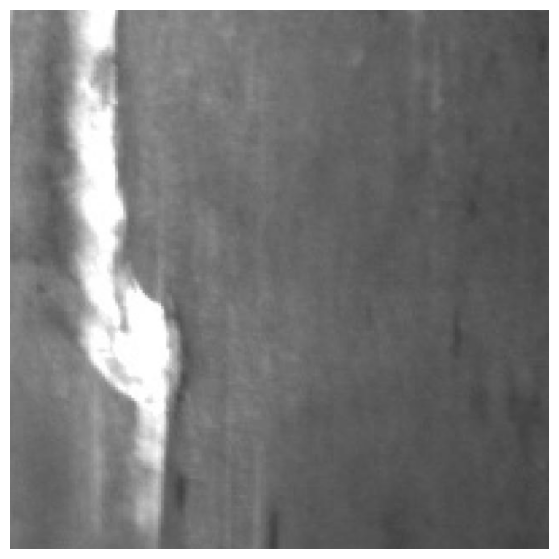

{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[309.4987, 199.9979, 621.7952, 434.2190],
        [ 43.5348, 438.3257, 239.7821, 610.3456],
        [ 48.7640, 253.5952, 238.2478, 605.9334]], device='cuda:0')), scores: tensor([0.7830, 0.6881, 0.5928], device='cuda:0'), pred_classes: tensor([5, 5, 5], device='cuda:0')])}


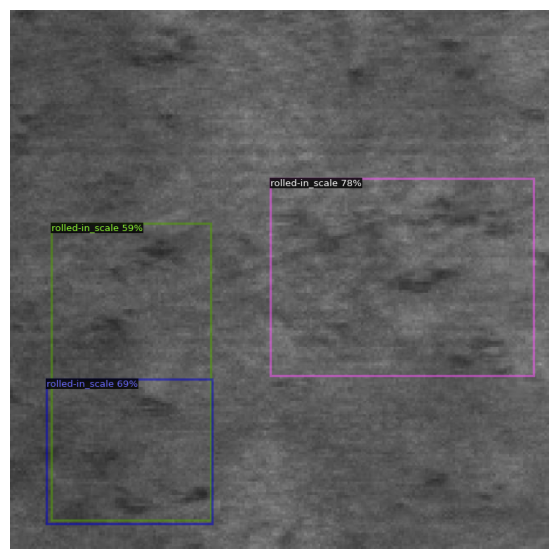

{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 17.8444,  27.1445, 459.0391, 265.4278],
        [164.7346,  10.3991, 611.3839, 195.3143],
        [ 23.6546, 147.5146, 589.8572, 444.4908]], device='cuda:0')), scores: tensor([0.5116, 0.5103, 0.5077], device='cuda:0'), pred_classes: tensor([1, 1, 1], device='cuda:0')])}


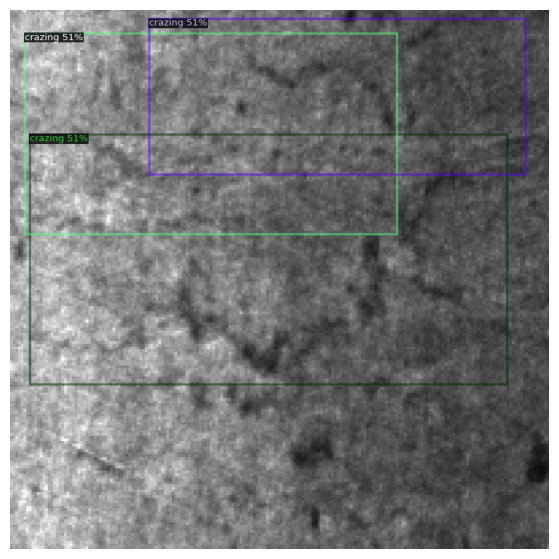

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[418.3536,  36.6082, 530.4136, 506.8734],
        [422.1717,  41.1831, 511.1313, 317.0670]], device='cuda:0')), scores: tensor([0.6279, 0.5710], device='cuda:0'), pred_classes: tensor([2, 2], device='cuda:0')])}


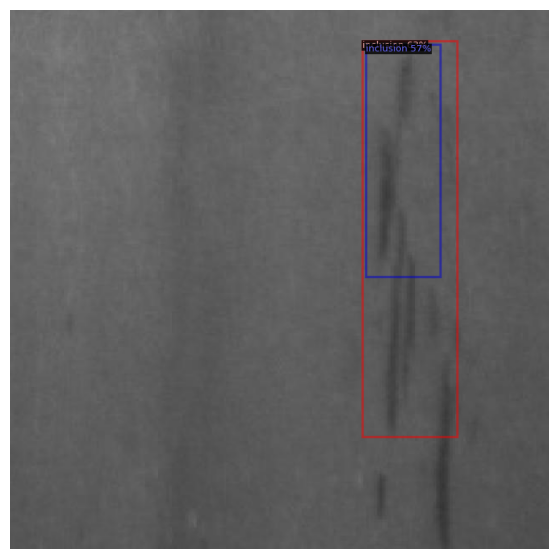

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 17.6146,  13.8940, 628.2474, 625.2794]], device='cuda:0')), scores: tensor([0.8975], device='cuda:0'), pred_classes: tensor([4], device='cuda:0')])}


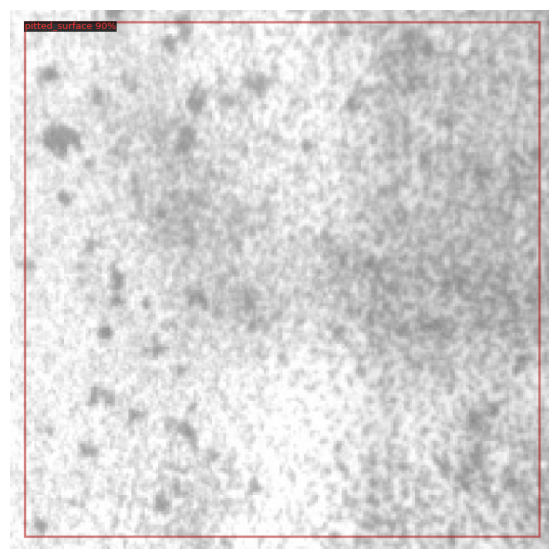

{'instances': Instances(num_instances=0, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


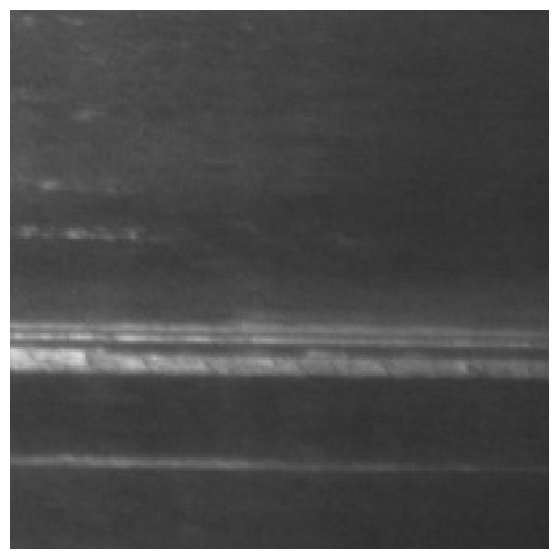

{'instances': Instances(num_instances=5, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[238.4950,  44.4806, 635.1275, 236.7303],
        [ 23.8757, 256.0628, 611.1108, 551.7099],
        [237.9612, 257.4032, 630.9536, 493.3564],
        [231.7831, 128.0201, 629.1755, 403.0670],
        [  6.4053, 319.1205, 432.8387, 603.5906]], device='cuda:0')), scores: tensor([0.5769, 0.5603, 0.5248, 0.5088, 0.5058], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1], device='cuda:0')])}


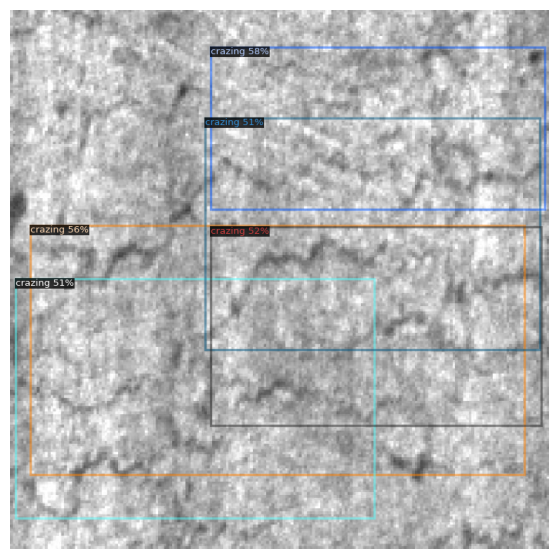

{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[437.7963, 490.8870, 491.6961, 623.1670],
        [ 36.6891, 230.8542, 140.2615, 494.7682],
        [430.9834, 171.3330, 491.1134, 367.0990]], device='cuda:0')), scores: tensor([0.5362, 0.5347, 0.5231], device='cuda:0'), pred_classes: tensor([2, 2, 2], device='cuda:0')])}


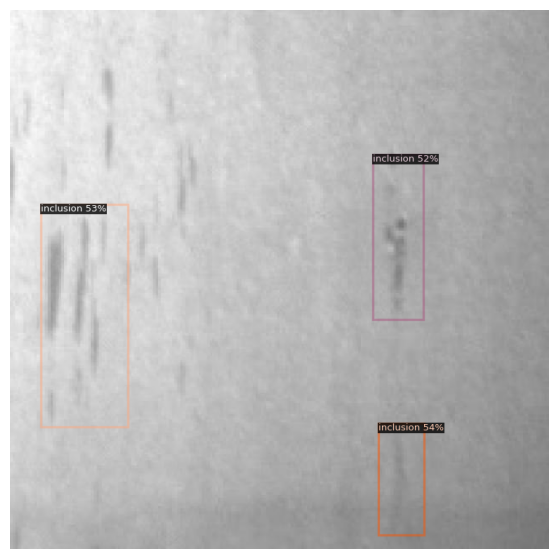

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 14.9841,   3.8558, 598.3122, 610.8040],
        [292.1720, 328.4110, 439.2332, 569.0070]], device='cuda:0')), scores: tensor([0.7324, 0.5064], device='cuda:0'), pred_classes: tensor([4, 3], device='cuda:0')])}


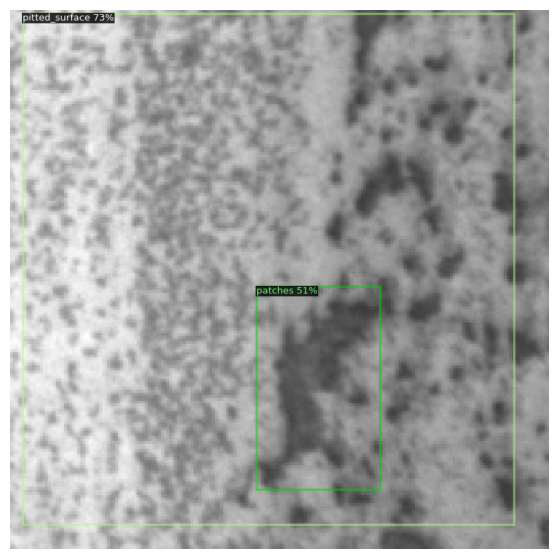

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 12.3333,  13.2412, 629.6108, 624.7045]], device='cuda:0')), scores: tensor([0.9034], device='cuda:0'), pred_classes: tensor([4], device='cuda:0')])}


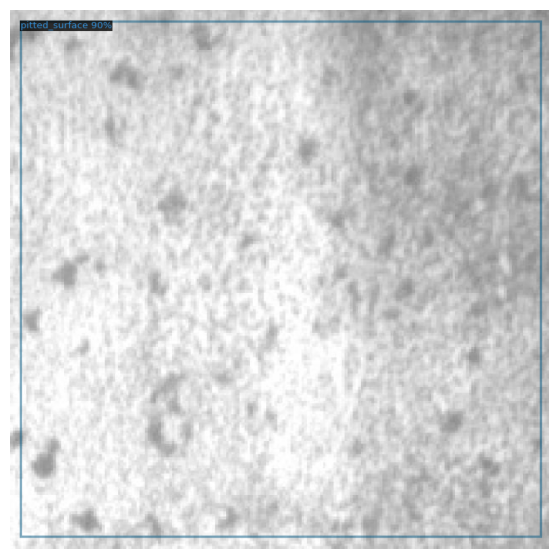

{'instances': Instances(num_instances=4, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[404.7638,  76.9312, 624.9534, 297.6386],
        [ 19.6179,  28.3815, 288.5069, 287.7068],
        [ 17.2468, 164.4744, 285.4030, 377.9089],
        [ 19.8103,   7.6297, 285.6382, 127.1824]], device='cuda:0')), scores: tensor([0.8128, 0.7514, 0.6375, 0.5513], device='cuda:0'), pred_classes: tensor([5, 5, 5, 5], device='cuda:0')])}


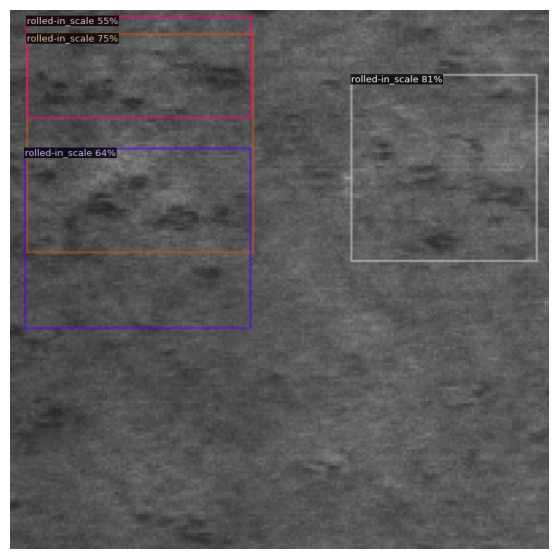

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 10.7065,   7.7091, 625.7216, 618.9578]], device='cuda:0')), scores: tensor([0.9057], device='cuda:0'), pred_classes: tensor([4], device='cuda:0')])}


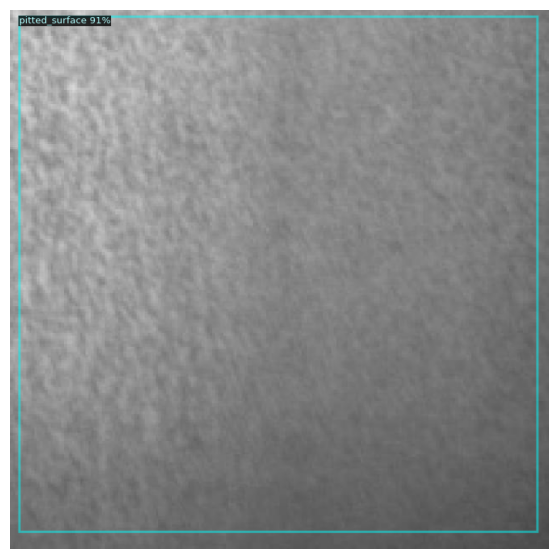

{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[221.6392,   8.8365, 416.6881, 161.7002],
        [188.8577, 281.6845, 424.3970, 528.5241],
        [ 29.9929,  24.5682, 162.5075, 152.3319]], device='cuda:0')), scores: tensor([0.7070, 0.6073, 0.5198], device='cuda:0'), pred_classes: tensor([5, 5, 5], device='cuda:0')])}


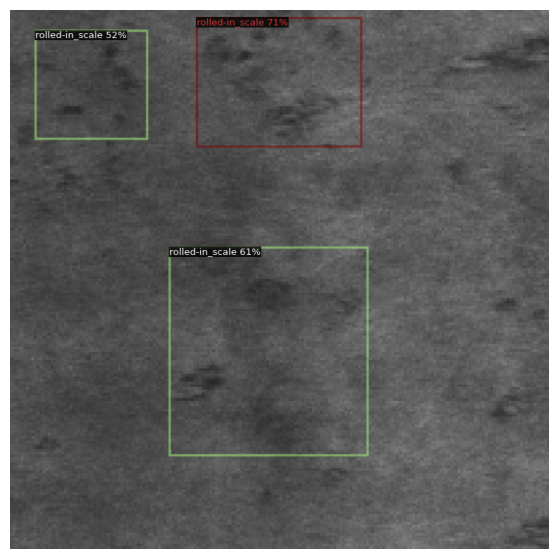

{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[400.9635, 205.1179, 633.3820, 624.4568],
        [ 12.4950,   8.3181, 229.3602, 567.7827],
        [428.4507,   0.0000, 511.4558,  50.6927]], device='cuda:0')), scores: tensor([0.8893, 0.7296, 0.6083], device='cuda:0'), pred_classes: tensor([3, 3, 3], device='cuda:0')])}


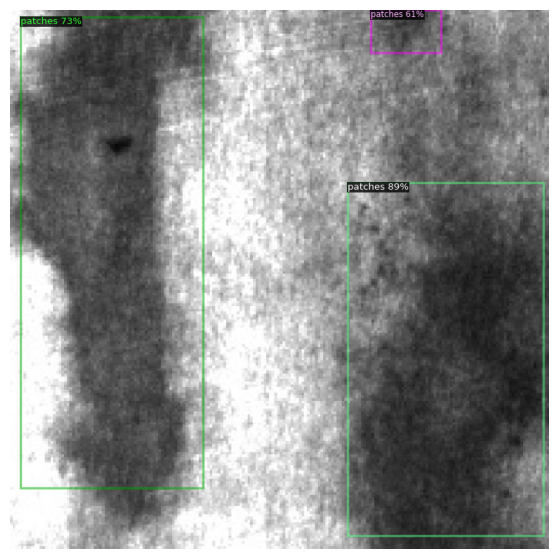

{'instances': Instances(num_instances=4, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[233.2696, 198.0550, 297.7985, 408.0465],
        [ 90.6487,  10.9828, 172.2741, 521.3397],
        [225.5640,  37.2310, 307.9359, 420.9075],
        [109.0947, 325.8745, 187.8720, 635.9188]], device='cuda:0')), scores: tensor([0.6133, 0.5917, 0.5712, 0.5037], device='cuda:0'), pred_classes: tensor([2, 2, 2, 2], device='cuda:0')])}


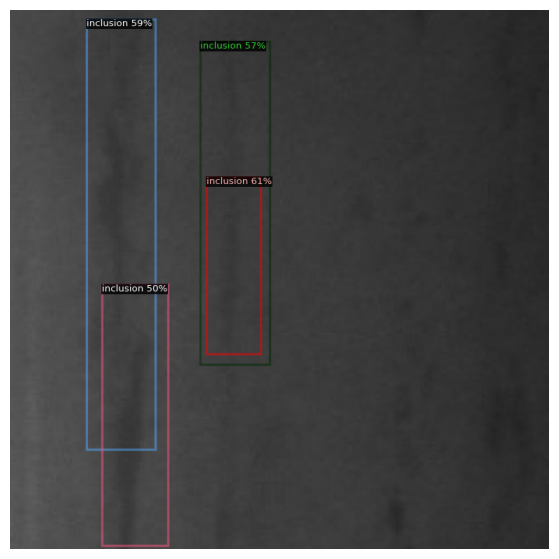

{'instances': Instances(num_instances=5, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[  6.3922,  13.6507, 471.9322, 212.2587],
        [136.6216,   9.3505, 613.9257, 190.5883],
        [ 17.6764,  39.6008, 601.8734, 341.2397],
        [ 18.8906, 279.2461, 599.1165, 507.6268],
        [  5.9575, 315.7750, 375.2295, 487.3025]], device='cuda:0')), scores: tensor([0.6607, 0.5808, 0.5761, 0.5744, 0.5709], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1, 1], device='cuda:0')])}


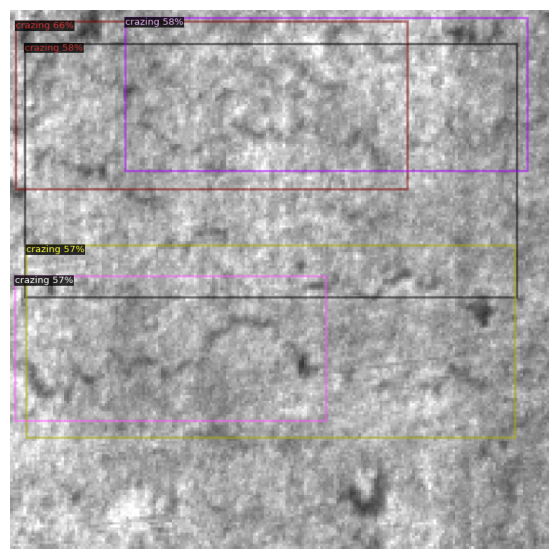

{'instances': Instances(num_instances=0, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


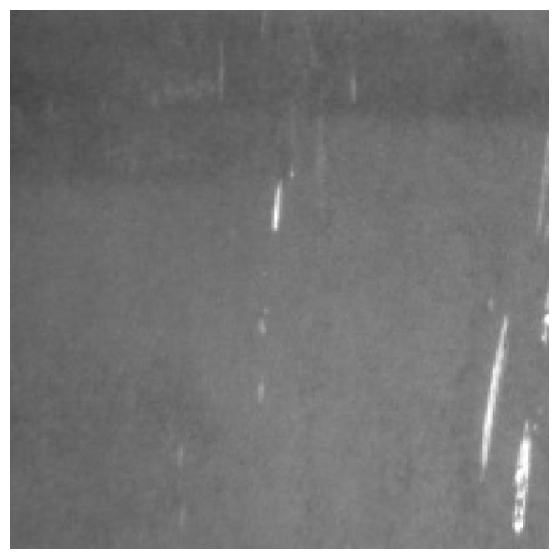

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[223.2337,  36.2622, 295.9601, 177.4624],
        [226.2480, 186.2358, 321.2054, 530.3586]], device='cuda:0')), scores: tensor([0.7892, 0.7789], device='cuda:0'), pred_classes: tensor([2, 2], device='cuda:0')])}


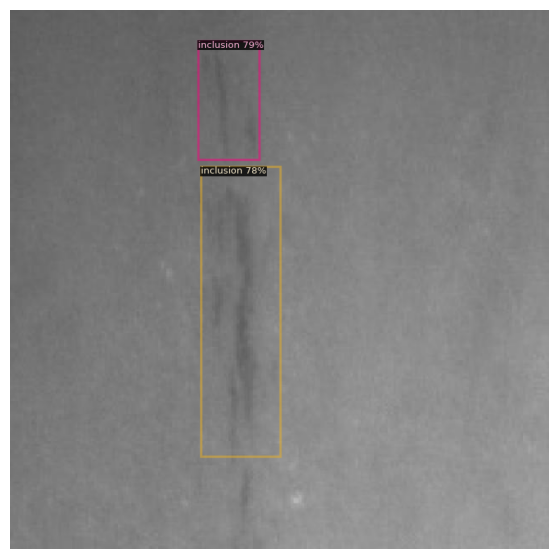

{'instances': Instances(num_instances=3, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[173.1738, 394.5479, 626.7847, 593.5854],
        [ 58.6666, 295.6909, 592.5438, 559.0424],
        [107.8764, 173.3372, 501.3069, 362.3501]], device='cuda:0')), scores: tensor([0.5461, 0.5186, 0.5151], device='cuda:0'), pred_classes: tensor([1, 1, 1], device='cuda:0')])}


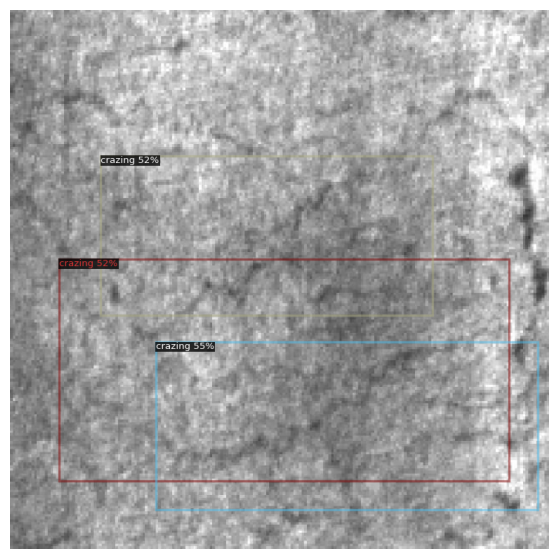

{'instances': Instances(num_instances=0, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


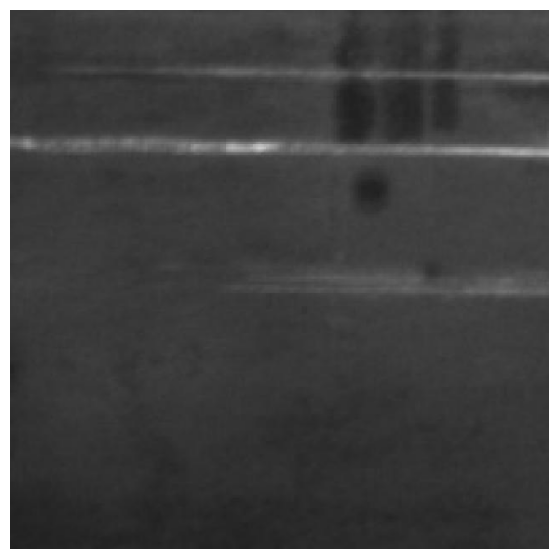

{'instances': Instances(num_instances=1, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[ 30.2334,  48.3052, 607.3522, 574.4123]], device='cuda:0')), scores: tensor([0.6743], device='cuda:0'), pred_classes: tensor([4], device='cuda:0')])}


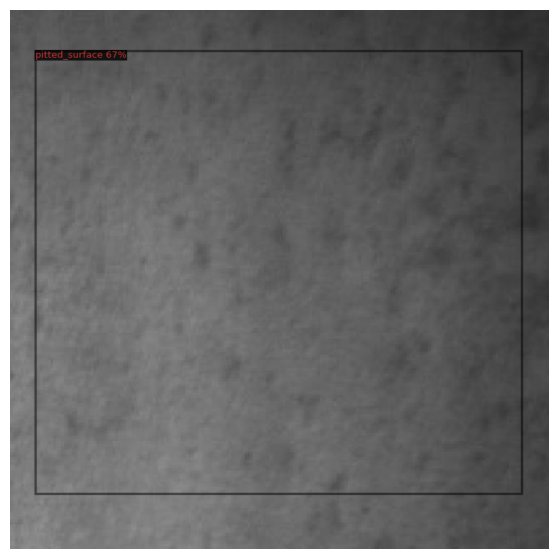

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[105.0835,  39.9469, 219.5187, 622.1523],
        [464.4665,  15.6586, 545.4026, 336.5905]], device='cuda:0')), scores: tensor([0.5213, 0.5182], device='cuda:0'), pred_classes: tensor([2, 2], device='cuda:0')])}


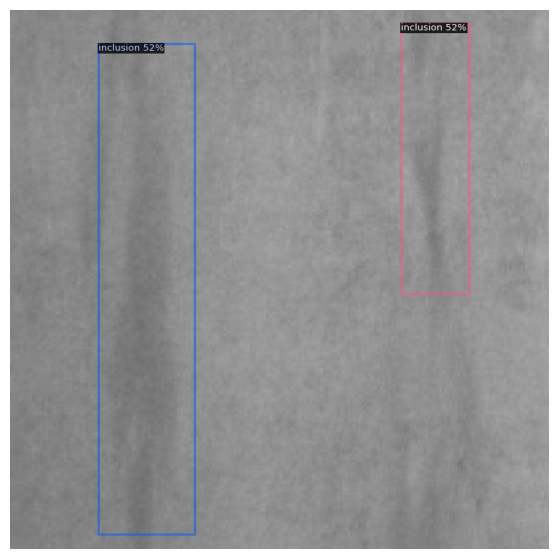

{'instances': Instances(num_instances=2, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[256.8686,  77.6125, 319.5899, 255.5729],
        [266.6223, 262.8377, 367.3615, 630.7160]], device='cuda:0')), scores: tensor([0.7827, 0.6627], device='cuda:0'), pred_classes: tensor([2, 2], device='cuda:0')])}


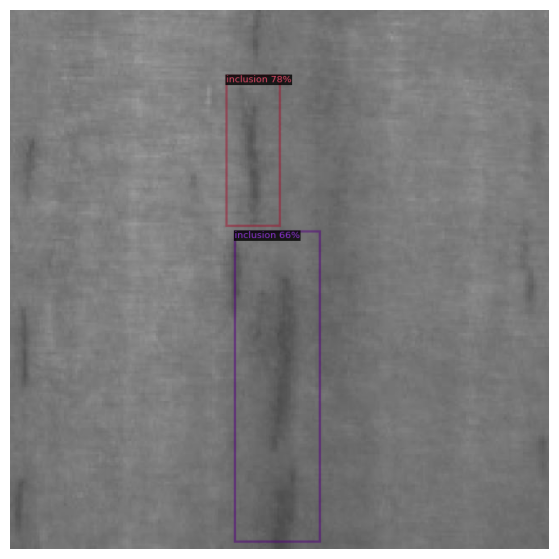

In [10]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
import glob
%matplotlib inline
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.RETINANET.NUM_CLASSES = 7
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
count=0
for img in glob.glob('/kaggle/working/NEUDET-Steel-Surface-Defects-4/valid/*.jpg'):
  if count ==25:
    break
  inputs = cv2.imread(img)
  outputs = predictor(inputs)
  print(outputs)
  v = Visualizer(inputs[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
  out = v.draw_instance_predictions(outputs['instances'].to('cpu'))
  plt.figure(figsize=(10, 7))
  plt.imshow(out.get_image())
  plt.axis('off')
  plt.show()

  count+=1

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")


print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`
# trainer.test()

[10/10 12:37:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


[10/10 12:37:48 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [10/10 12:37:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/10 12:37:48 d2.data.datasets.coco]: Loaded 368 images in COCO format from /kaggle/working/NEUDET-Steel-Surface-Defects-4/valid/_annotations.coco.json
[10/10 12:37:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/10 12:37:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/10 12:37:48 d2.data.common]: Serializing 368 elements to byte tensors and concatenating them all ...
[10/10 12:37:48 d2.data.common]: Serialized dataset takes 0.13 MiB
[10/10 12:37:48 d2.evaluation.evaluator]: Start inference on 368 batches


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[10/10 12:37:49 d2.evaluation.evaluator]: Inference done 11/368. Dataloading: 0.0012 s/iter. Inference: 0.0715 s/iter. Eval: 0.0002 s/iter. Total: 0.0728 s/iter. ETA=0:00:25
[10/10 12:37:54 d2.evaluation.evaluator]: Inference done 79/368. Dataloading: 0.0014 s/iter. Inference: 0.0725 s/iter. Eval: 0.0002 s/iter. Total: 0.0741 s/iter. ETA=0:00:21
[10/10 12:37:59 d2.evaluation.evaluator]: Inference done 146/368. Dataloading: 0.0016 s/iter. Inference: 0.0729 s/iter. Eval: 0.0002 s/iter. Total: 0.0748 s/iter. ETA=0:00:16
[10/10 12:38:04 d2.evaluation.evaluator]: Inference done 213/368. Dataloading: 0.0016 s/iter. Inference: 0.0731 s/iter. Eval: 0.0002 s/iter. Total: 0.0750 s/iter. ETA=0:00:11
[10/10 12:38:09 d2.evaluation.evaluator]: Inference done 279/368. Dataloading: 0.0016 s/iter. Inference: 0.0734 s/iter. Eval: 0.0002 s/iter. Total: 0.0753 s/iter. ETA=0:00:06
[10/10 12:38:14 d2.evaluation.evaluator]: Inference done 345/368. Dataloading: 0.0016 s/iter. Inference: 0.0736 s/iter. Eval: 0

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


[10/10 12:38:16 d2.evaluation.evaluator]: Total inference time: 0:00:27.454609 (0.075633 s / iter per device, on 1 devices)
[10/10 12:38:16 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:26 (0.073658 s / iter per device, on 1 devices)
[10/10 12:38:16 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/10 12:38:16 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[10/10 12:38:16 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.146
 Average

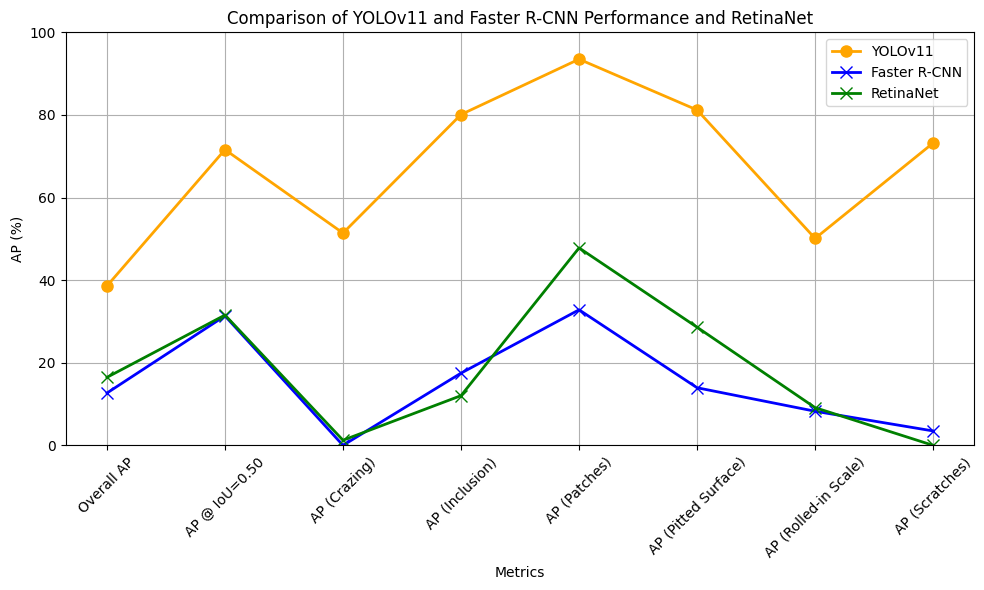

In [17]:
import matplotlib.pyplot as plt

# Data for the metrics
metrics = [
    "Overall AP",
    "AP @ IoU=0.50",
    "AP (Crazing)",
    "AP (Inclusion)",
    "AP (Patches)",
    "AP (Pitted Surface)",
    "AP (Rolled-in Scale)",
    "AP (Scratches)"
]

yolo_scores = [
    38.6,
    71.6,
    51.4,
    80.1,
    93.5,
    81.2,
    50.1,
    73.2
]

faster_rcnn_scores = [
    12.67,
    31.35,
    0.0,
    17.49,
    32.82,
    13.95,
    8.26,
    3.49
]

retinanet_scores = [
    16.47,
    31.55,
    1.24,
    12.04,
    47.81,
    28.60,
    9.13,
    0.00
]

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plotting the lines and points
plt.plot(metrics, yolo_scores, label='YOLOv11', marker='o', color='orange', markersize=8, linewidth=2)
plt.plot(metrics, faster_rcnn_scores, label='Faster R-CNN', marker='x', color='blue', markersize=8, linewidth=2)
plt.plot(metrics, retinanet_scores, label='RetinaNet', marker='x', color='green', markersize=8, linewidth=2)
# Adding labels and title
plt.title('Comparison of YOLOv11 and Faster R-CNN Performance and RetinaNet')
plt.xlabel('Metrics')
plt.ylabel('AP (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Setting y-axis limits for better comparison
plt.grid()
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import cv2
import random
import gc
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances

# Set up logger
setup_logger()

# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.RETINANET.NUM_CLASSES = 7
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

# Set up confusion matrix
conf_mat = np.zeros((cfg.MODEL.RETINANET.NUM_CLASSES, cfg.MODEL.RETINANET.NUM_CLASSES))

# Process batches
for d in DatasetCatalog.get("my_dataset_test"):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    instances = outputs["instances"]

    for pred_class, pred_score, pred_box, gt_class in zip(
        instances.pred_classes, instances.scores, instances.pred_boxes, [d["annotations"][0]["category_id"]]
    ):
        conf_mat[gt_class, pred_class] += 1

[09/25 08:59:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [09/25 08:59:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/25 08:59:57 d2.data.datasets.coco]: Loaded 368 images in COCO format from /kaggle/working/NEUDET-Steel-Surface-Defects-4/valid/_annotations.coco.json


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


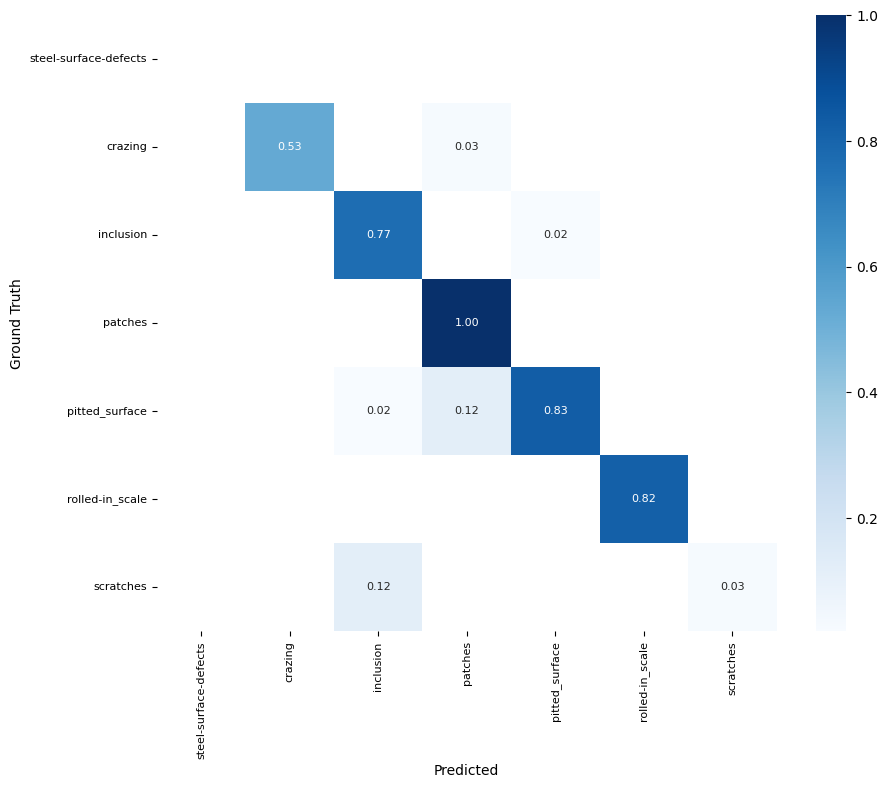

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#hh
# ...
conf_mat_normalized = np.round(conf_mat / conf_mat.max(), 2)
# Print confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=MetadataCatalog.get("my_dataset_train").thing_classes, yticklabels=MetadataCatalog.get("my_dataset_train").thing_classes, mask=(conf_mat_normalized==0), annot_kws={"fontsize": 8})
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()